# Proyecto: Web Scraping y Análisis de sentimiento de reviews de la web IMDB

<div>
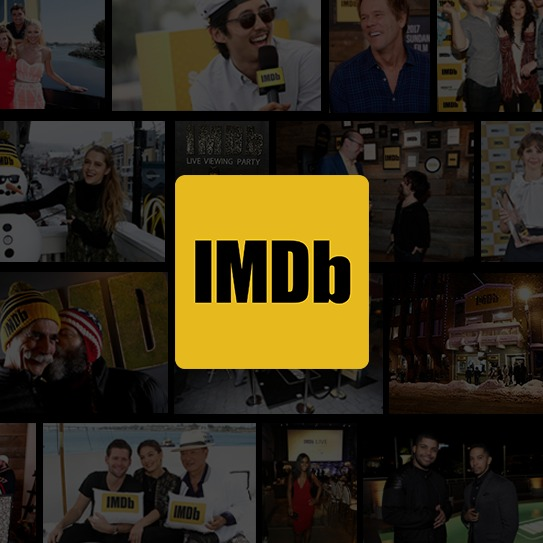
</div>



En este proyecto, nos proponemos realizar un análisis de datos para extraer información valiosa a partir de las reviews de películas. El objetivo es acceder a una página web, recopilar estas reviews, analizar el sentimiento asociado y asignar una puntuación a cada película.

Desarrollaremos todo el trabajo en este notebook, utilizando Python como lenguaje de programación y herramientas de ETL. El proyecto se estructura en tres fases principales:

1. En la primera fase, revisaremos el alcance del proyecto y crearemos una base de datos para almacenar los resultados. También implementaremos una función que transformará las etiquetas de sentimiento en valores numéricos.

2. La segunda fase se centrará en la implementación de técnicas de Web Scraping para extraer datos de las reviews de la web de IMDB, utilizando la librería *`BeautifulSoup`*. Automatizaremos el proceso para permitir la búsqueda de cualquier película a través de la librería selenium.

3. Finalmente, en la tercera fase, utilizaremos una **API de análisis de sentimientos** que recibirá el texto de cada review y devolverá una etiqueta de sentimiento categorizada. Transformaremos estas etiquetas en valores numéricos y almacenaremos los resultados en la base de datos creada previamente.

In [ ]:
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
import time
import requests
import sqlite3
from selenium.webdriver.chrome.options import Options

## Extracción de las opiniones (reviews) y las puntuaciones (ratings)

En esta fase, utilizaremos `BeautifulSoup` para extraer las reviews de una película determinada, por ejemplo:
https://www.imdb.com/title/tt1517268/reviews/?ref_=tt_ov_rt

En primer lugar, extraemos los textos de las reviews y los almacenamos en una lista  


In [ ]:
# URL de las reviews de la película
url = 'https://www.imdb.com/title/tt1517268/reviews/?ref_=tt_ov_rt'

# Hacemos una petición GET a la URL
response = requests.get(url)

# Parseamos el contenido HTML de la página con BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Extraemos los textos de las reviews
reviews = []
review_divs = soup.find_all('div', class_='text show-more__control')
for div in review_divs:
    reviews.append(div.get_text(strip=True))

Imprimimos por pantalla la primera y última review para comprobar que el código funciona

In [ ]:
#Visualizamos la primera review
print("Primera review:")
print(reviews[0])

Primera review:
As a woman that grew up with Barbie, I was very excited for this movie. I was curious to see how they would evolve the "stereotypical Barbie" into something more. But the messaging in this movie was so heavy handed that it completely lost the plot. I consider myself a proponent of gender equality, and this ain't the way to get it.Barbieland flips the script on the patriarchy of the real world, giving women the power and leaving the Kens as attractive accessories. Once Ken gets a glimpse of the real world he brings the patriarchy to Barbieland and the Barbies are "brainwashed" (this happens suddenly and without much explanation). The Kens are bumbling fools with zero understanding of governance, and Barbieland falls into disarray.The movie's solution to this is for the Barbies to give a lot of Ted talks on the patriarchy, fool the Kens into war with each other, and rule once again. But isn't the point if gender equality... equality?The feminist messaging could have been 

In [ ]:
#Visualizamos la última review
print("Última review:")
print(reviews[-1])

Última review:
Greta Gerwig and Noah Baumbach have a knack for incorporating the many little observations of life, whether funny or deeply interpersonal, into a screenplay. Gerwig manages to direct them with great visuals and clever transitions.Unfortunately, the only major weakness of the film, in my opinion, also lies in the screenplay. When dealing with larger societal issues, it lacks depth and possibly understanding. The observations work, but the contextualization falls short. The approach feels crude and superficial. This creates a confusing overall impression, as the finely crafted small observations remain convincing. A film that is so intelligent, funny, and creative on an individual level suddenly seems foolish in the grand scheme of things.Key moments in the film, such as the encounter with the inventor, fail to evoke emotions and come across as insincere. The angry rant about the struggles of being a woman feels cheap. There seems to be a lack of sensitivity, as if someone

In [ ]:
#Contamos el número de reviews que se han conseguido extraer
print(f"La longitud de las reviews es: {len(reviews)}")

La longitud de las reviews es: 25


In [ ]:
# Extraemos las puntuaciones de los usuarios y los almacenamos en la lista rating
ratings = []
rating_spans = soup.find_all('span', class_='rating-other-user-rating')

for span in rating_spans:
    # Encontramos el primer span dentro del span con clase rating-other-user-rating
    rating_value = span.find('span')
    if rating_value:
        rating_text = rating_value.get_text(strip=True)
        if rating_text.isdigit():  # Asegurarse de que el texto sea un número
            ratings.append(int(rating_text))

In [ ]:
# Comporbamos la longitud de los rating

print(f"La longitud de las ratings es: {len(ratings)}")

La longitud de las ratings es: 22


Las longitudes de ratings y de reviews no coinciden porque, si nos fijamos en el sitio web, podemos ver que hay algunas reviews que no tienen un rating asociado.

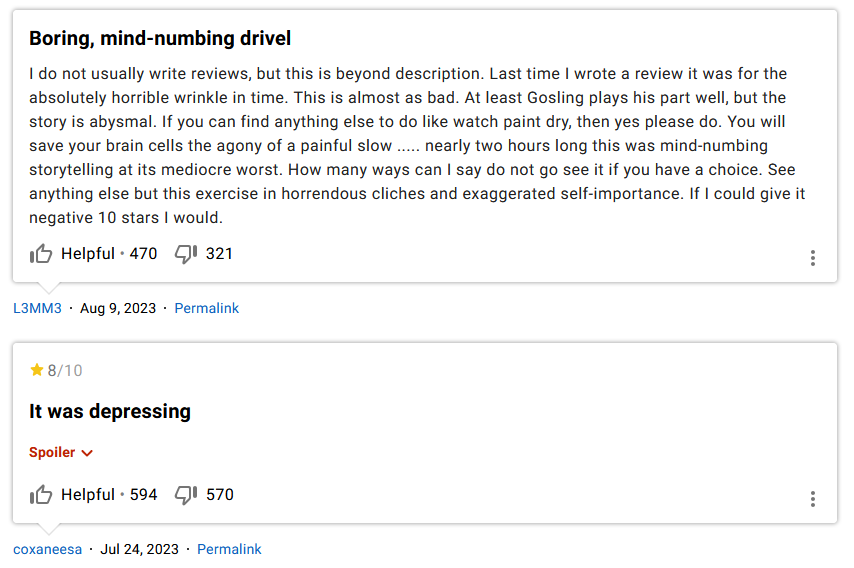

In [ ]:
# Obtenemos la nota media de las reviews extraidas

average_rating = round(sum(ratings) / len(ratings), 2)
print(f"La nota media de las reviews es: {average_rating}")

La nota media de las reviews es: 6.68


# Implementación de selenium

Vamos a usar `selenium` para poder automatizar el proceso de obtención de las URLs de otras películas.

Partiendo de https://www.imdb.com, vamos a utilizar el buscador de películas y a navegar por las páginas web con selenium hasta la página de reviews de usuarios de la palícula correspondiente


In [ ]:
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException, NoSuchElementException, ElementClickInterceptedException

# Configuración de Selenium y el navegador Chrome
chrome_options = Options()
chrome_options.add_argument("--disable-gpu")  # Aplicable a Windows
chrome_options.add_argument("--window-size=1920,1080")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Descargar e instalar el controlador de Chrome
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

try:
    # URL principal de IMDb
    base_url = 'https://www.imdb.com'

    # Navegar a la página principal de IMDb
    driver.get(base_url)

    # Esperar a que la barra de búsqueda esté presente
    wait = WebDriverWait(driver, 10)
    search_box = wait.until(EC.presence_of_element_located((By.NAME, 'q')))

    # Introducir el título de la película en la barra de búsqueda
    movie_title = "Barbie"  # Cambiar por el título de la película que queráis buscar
    search_box.send_keys(movie_title)

    # Esperar a que aparezcan los resultados de la búsqueda
    first_result = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div.sc-efHYhv.cOfHwX')))
    first_result.click()

    # Esperar a que se cargue la página de la película
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'h1')))

    # Navegar a la sección de "Reseñas de usuarios"
    reviews_link = wait.until(EC.presence_of_element_located((By.XPATH, '//h3[contains(., "Reseñas de usuarios")]')))

    try:
        reviews_link.click()
    except ElementClickInterceptedException:
        driver.execute_script("arguments[0].click();", reviews_link)

    # Esperar a que se cargue la página de reviews
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div.lister-list')))

    # Obtener la URL actual (que debería ser la página de reviews)
    reviews_url = driver.current_url

    # Imprimir la URL de la página de reviews
    print("URL de la página de reviews:", reviews_url)

except TimeoutException:
    print(f"No se encontraron resultados para la película '{movie_title}'. Por favor, verificad el título e intentad de nuevo.")
except NoSuchElementException:
    print("No se pudo encontrar un elemento esperado en la página. Por favor, revisad el script y los selectores utilizados.")
finally:
    # Cerrar el navegador
    driver.quit()

Una vez hayamos conseguido llegar a la URL de cualquier película, unificamos todo el código en una función llamada `extract_reviews`, la cual reciba como argumento el nombre de la película y devuelva un diccionario con tres elementos:

* Una lista llamada `reviews`, que contiene los textos de las reseñas
* Una lista llamada `scores`, que contiene las puntuaciones de los usuarios
* El valor de la nota media de las reviews en una variable llamada `avg_score`

In [ ]:

def extract_reviews(movie_title):

    # Configuración de Selenium y el navegador Chrome
    chrome_options = Options()
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--window-size=1920,1080")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")

    # inicializo el webdriver
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

    # accedo a la web de IMDB
    base_url = 'https://www.imdb.com'
    driver.get(base_url)

    # Busco la película

    wait = WebDriverWait(driver, 10) # Esperar a que la barra de búsqueda esté presente
    search_box = wait.until(EC.presence_of_element_located((By.NAME, 'q')))

    search_box.send_keys(movie_title)  # Introducir el título de la película en la barra de búsqueda

    time.sleep(2) # Esperar a que aparezcan los resultados de la búsqueda
    first_result = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div.sc-efHYhv.cOfHwX')))


    # click en la tecla enter (en mi caso accedo al primer resultado del manu desplegable de la barra de búsqueda)
    first_result.click()

    # accedo a las reseñas de los usuarios

    # Esperar a que se cargue la página de la película
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'h1')))

    # Navegar a la sección de "Reseñas de usuarios"
    reviews_link = wait.until(EC.presence_of_element_located((By.XPATH, '//h3[contains(., "Reseñas de usuarios")]')))

    try:
        reviews_link.click()
    except ElementClickInterceptedException:
        driver.execute_script("arguments[0].click();", reviews_link)

    # Esperar a que se cargue la página de reviews
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div.lister-list')))

    # cargo más reviews

    while True:
        load_more_button = wait.until(EC.presence_of_element_located((By.ID, 'load-more-trigger')))
        if load_more_button.is_displayed() and load_more_button.is_enabled():
            driver.execute_script("arguments[0].scrollIntoView(true);", load_more_button)
            try:
                load_more_button.click()
                time.sleep(2)  # Esperar un momento para que las nuevas reseñas se carguen
            except ElementClickInterceptedException:
                driver.execute_script("arguments[0].click();", load_more_button)
        else:
            break

    # extraigo el html de la página y lo convierto a un objeto de BeautifulSoup
    page_content = driver.page_source
    soup = BeautifulSoup(page_content, 'html.parser')

    # cierro el driver
    driver.quit()

    # extraigo las reviews
    review_elements = soup.select('div.lister-item-content div.content div.text')
    reviews = [review.get_text(strip=True) for review in review_elements]

    # extraigo los ratings

    ratings = []
    rating_spans = soup.find_all('span', class_='rating-other-user-rating')
    for span in rating_spans:
        # Encontrar el primer span dentro del span con clase rating-other-user-rating
        rating_value = span.find('span')
        if rating_value:
            rating_text = rating_value.get_text(strip=True)
            if rating_text.isdigit():  # Asegurarse de que el texto sea un número
                ratings.append(int(rating_text))

    # calculo la nota media

    avg_score = round(sum(ratings) / len(ratings), 2) if ratings else 0.0

    # salida de la función

    return {
        'reviews': reviews,
        'scores': ratings,
        'avg_score': avg_score
    }

In [ ]:
# Probamos la función en la película de moda Barbie

extract_reviews('Barbie')

{'reviews': ['As a woman that grew up with Barbie, I was very excited for this movie. I was curious to see how they would evolve the "stereotypical Barbie" into something more. But the messaging in this movie was so heavy handed that it completely lost the plot. I consider myself a proponent of gender equality, and this ain\'t the way to get it.Barbieland flips the script on the patriarchy of the real world, giving women the power and leaving the Kens as attractive accessories. Once Ken gets a glimpse of the real world he brings the patriarchy to Barbieland and the Barbies are "brainwashed" (this happens suddenly and without much explanation). The Kens are bumbling fools with zero understanding of governance, and Barbieland falls into disarray.The movie\'s solution to this is for the Barbies to give a lot of Ted talks on the patriarchy, fool the Kens into war with each other, and rule once again. But isn\'t the point if gender equality... equality?The feminist messaging could have been

## API MEANING CLOUD

En esta fase, utilizaremos una API para extraer el sentimiento de las reviews. Existen numeroros servicios web que nos ofrecen sus servicios de análisis de sentimiento. Para este proyecto, utilizaremos [Meaningcloud](https://www.meaningcloud.com/), cuya API proporciona analítica de texto de manera gratuita hasta 100 peticiones mensuales.

<p>
<div>
<img src="https://www.meaningcloud.com/developer/img/LogoMeaningCloud210x85.png" width="150" align="left">
</div>  
</p>
        


In [ ]:
import requests

def sentim(lang,text):
    api_key = '0585f8a0ed8d3131b6e426ec25465498'
    url = "https://api.meaningcloud.com/sentiment-2.1"
    payload = {
        'key': api_key,
        'lang': lang,
        'txt': text
    }

    response = requests.post(url, data=payload)
    result = response.json()

    # Manejar la respuesta de la API
    if result['status']['code'] == '0':
        sentiment = result['score_tag']
        return sentiment
    else:
        print(f"Error: {result['status']['msg']}")
        return None

Aplicamos la función con alguna review obtenida en el apartado anterior

In [ ]:
# Escribe aquí tu código

language = "en"  # Código de idioma, por ejemplo, 'en' para inglés
text = "The dishes were very good and the price was OK. I recommend it"

sentiment = sentim(language, text)
print(f"Sentimiento: {sentiment}")

Sentimiento: P+


Tal y cómo indica la documnetación de la API, ésta nos devuelva los resultados:

- Muy positiva: `P+`
- Positiva: `P`
- Neutral: `NEU`
- Negativa: `N`
- Muy Negativa: `N+`

Para poder iterpretar de manera más sencilla los resultados obtenidos con la API MEANING CLOUD vamos a crear la función `sent2num` que recibirá como entrada una lista con las etiquetas de sentimiento en forma de string, y generará un score numérico, de la siguiente forma:

- Las reviews `P+` sumarán +2 puntos
- Las reviews `P` sumarán +1 punto
- Las reviews `NEU` no sumarán ni restarán
- Las reviews `N` restarán -1 punto
- Las reviews `N+` restarán -2 puntos

El score final será el valor obtenido dividido por el número de reviews. Por ejemplo, una película con 6 reviews con las siguientes etiquetas:

`['P+', 'P', 'P+', 'NEU', 'N+', 'N']`

tendrá el siguiente score:

$\frac{2+1+2+0-2-1}{6}=\frac{2}{6}=0.33$


In [ ]:
def sent2num(reviews):

    # Definimos las etiquetas de sentimiento a valores numéricos

    sentiment_map = {
        'P+': 2,
        'P': 1,
        'NEU': 0,
        'N': -1,
        'N+': -2
    }

    # Calculamos el score total sumando los valores mapeados de las etiquetas
    total_score = sum(sentiment_map[review] for review in reviews)

    # Calculamos el score final dividiendo por el número de reviews y redondeando a dos decimales
    final_score = round(total_score / len(reviews), 2)

    return final_score

In [ ]:
#Primero ejecutamos la función extract_reviews() y guardamos los resultados en result.
result = extract_reviews('Barbie')
reviews = result['reviews'][:40]

Se realiza el análisis de sentimientos para 40 de los reviews para no sobrepasar el límite de la API.

In [ ]:
# Lista para almacenar los sentimientos de cada reseña
sentiments = []

# Analizar el sentimiento de cada reseña
for review in reviews:
    sentiment = sentim('en', review)
    sentiments.append(sentiment)

# Mostramos cada review analizada y debajo ponemos el sentimiento predicho por el modelo
print("Reseñas:")
for i, review in enumerate(reviews):
    print(f"Reseña {i+1}: {review}")
    print(f"Sentimiento: {sentiments[i]}")

Reseñas:
Reseña 1: As a woman that grew up with Barbie, I was very excited for this movie. I was curious to see how they would evolve the "stereotypical Barbie" into something more. But the messaging in this movie was so heavy handed that it completely lost the plot. I consider myself a proponent of gender equality, and this ain't the way to get it.Barbieland flips the script on the patriarchy of the real world, giving women the power and leaving the Kens as attractive accessories. Once Ken gets a glimpse of the real world he brings the patriarchy to Barbieland and the Barbies are "brainwashed" (this happens suddenly and without much explanation). The Kens are bumbling fools with zero understanding of governance, and Barbieland falls into disarray.The movie's solution to this is for the Barbies to give a lot of Ted talks on the patriarchy, fool the Kens into war with each other, and rule once again. But isn't the point if gender equality... equality?The feminist messaging could have be

Sobre esa lista, aplica la función implementada en la Fase 1 para extraer un score

In [ ]:
# Aplicamos la función sent2num a estos 40 reviews
sent2num(sentiments)

0.45

In [ ]:
# Comprobamos la nota sobre 10 que obtenemos con la API CLOUD MEANING

# Normalizamos el resultado para convertir la nota que da sent2num, que va del -2 a 2, al rango de 0 a 10

avg_sentiment_score = sent2num(sentiments)
normalized_avg_sentiment_score = (avg_sentiment_score + 2) / 4 * 10

print(f"Nota media calculada con sent2num (normalizada): {normalized_avg_sentiment_score}")
print(f"Nota media calculada de la página de IMDb: {result['avg_score']}")


Nota media calculada con sent2num (normalizada): 6.125
Nota media calculada de la página de IMDb: 6.77


Cómo podemos ver los dos métodos dan una media parecida, así que podemos apreciar que el modelo de análisis de sentimientos  funciona significativamente bien.

## Almacenamos los resultados en una base de datos

A continuación, creamos una base de datos utilizando SQLite, con el nombre "BBDD_reviews.sqlite". En esta base de datos almacenaremos los resultados finales.

In [ ]:
# Nos conectamos a la base de datos (si no existe, se creará)
conn = sqlite3.connect('BBDD_reviews.sqlite')

# Creamos un cursor para interactuar con la base de datos
cursor = conn.cursor()

Finalmente vamos a almacenar el resultado en la base de datos. Vamos a cargarlos en una tabla llamada `movies`, generando una fila con la siguiente estructura:
| Movie      | AvgScore | Sentiment |
|------------|----------|-----------|
| El Padrino | 9.6      | 0.8       |


In [ ]:
import sqlite3

cursor.execute('''
    DROP TABLE IF EXISTS movies

''')

# Crear la tabla 'movies' si no existe
cursor.execute('''
    CREATE TABLE IF NOT EXISTS movies (
        Movie TEXT,
        AvgScore REAL,
        Sentiment REAL
    )
''')

# Insertar el registro en la tabla
cursor.execute('''
    INSERT INTO movies (Movie, AvgScore, Sentiment)
    VALUES (?, ?, ?)
''', ("El Padrino", 9.6, 0.8))

# Confirmar los cambios y cerrar la conexión
conn.commit()

# Consultar todos los registros de la tabla 'movies'
cursor.execute('SELECT * FROM movies')
rows = cursor.fetchall()

# Mostrar los registros
print("Registros en la tabla 'movies':")
for row in rows:
    print(row)

Registros en la tabla 'movies':
('El Padrino', 9.6, 0.8)


In [ ]:
movie_title = movie_title
imdb_avg_score = result['avg_score']
sentiments = normalized_avg_sentiment_score

# Insertar el registro en la tabla
cursor.execute('''
    INSERT INTO movies (Movie, AvgScore, Sentiment)
    VALUES (?, ?, ?)
''', (movie_title, imdb_avg_score, sentiments))

# Confirmar los cambios y cerrar la conexión
conn.commit()

# Consultar todos los registros de la tabla 'movies'
cursor.execute('SELECT * FROM movies')
rows = cursor.fetchall()

# Mostrar los registros
print("Registros en la tabla 'movies':")
for row in rows:
    print(row)

Registros en la tabla 'movies':
('El Padrino', 9.6, 0.8)
('Barbie', 6.77, 6.125)
